In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path


Train shape: (140255, 14) Test shape: (17373, 14)
XGBoost on 2025 data → RMSE: 104685.74, MAE: 80322.03, MAPE: 4.64%


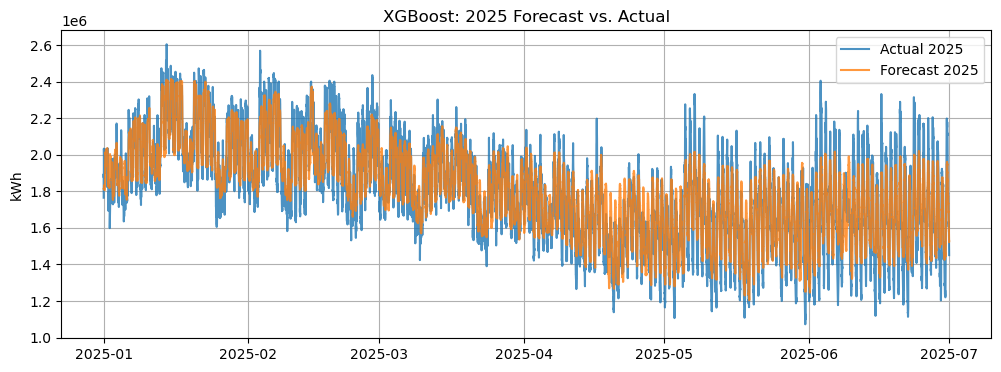

In [2]:

feat_path = Path("../data/processed/electricity_features_15min.csv")
df = pd.read_csv(feat_path, parse_dates=['datetime'], index_col='datetime')

# —————————————
# Data split by date (train: ≤2024-12-31, test: 2025-01-01 onward)
# —————————————
train = df.loc[: "2024-12-31 23:45"]   # all data up to end of 2024
test  = df.loc["2025-01-01":]           # all 2025 data

X_train = train.drop(columns=['total_consumption_kWh'])
y_train = train['total_consumption_kWh']
X_test  = test.drop(columns=['total_consumption_kWh'])
y_test  = test['total_consumption_kWh']

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


# —————————————
# Train XGBoost
# —————————————
xgb = XGBRegressor(
    n_estimators=1000, learning_rate=0.01,
    max_depth=6, subsample=0.8, colsample_bytree=0.8,
    random_state=69, verbosity=1
)
xgb.fit(X_train, y_train)

# —————————————
# Forecast & Evaluation.
# —————————————

y_pred = xgb.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100

print(f"XGBoost on 2025 data → RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")


# —————————————
# Plot.
# —————————————

plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test,  label='Actual 2025', alpha=0.8)
plt.plot(y_test.index, y_pred,  label='Forecast 2025', alpha=0.8)
plt.title("XGBoost: 2025 Forecast vs. Actual")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.show()
